# PyMME Tutorial

This is an example PyMME script, showing how to use XCast to construct, assess, and compare Multi-Model Ensemble forecasts using different statistical techniques. It also demonstrates Xarray data manipulation. Please refer to the [XCast](https://github.com/kjhall01/xcast/blob/main/XCAST_DOCS.md) and [Xarray](http://xarray.pydata.org/en/stable/) documentation for even more detail on the functions used. 


### Data Ingestion & Preparation
In this first section, we import Xarray and XCast, as well as a plotting utility called PyPlot. We then use Xarray to load our example data from NetCDF files, and to get it into an appropriate format for XCast. For this example, we will make MME forecasts using prepared NCEP-CFSv2, CanSIPSv2, and COLA-RSMAS-CCSM4 precipitation forecasts in NetCDF format as predictors, and CPC-CMAP-URD precipitation as a predictand.

In [1]:
# importing libraries
import src as xc    # This line will become "import xcast as xc" once xcast is installed with anaconda
import xarray as xr  #import xarray
import matplotlib.pyplot as plt  #need this for multi-plotting, for now.
import cartopy.crs as ccrs # geomapping library

# Opening example datasets:
#    - Each dataset is only three-dimensional - sample x lat x lon - so they need to be 
#      concatenated along a new axis, "feature," which will have the name, "M". 
#    - We use 'decode_times=False' because the NetCDF files' time-coordinates don't adhere 
#      to the proper standards. Other files won't necessarily require that. 
obs = xr.open_dataset('test_data/cpc_jaso_asia_full.nc', decode_times=False)
cola = xr.open_dataset('test_data/cola_jaso_asia_full.nc', decode_times=False)
cansipsv2 = xr.open_dataset('test_data/cansipsv2_jaso_asia_full.nc', decode_times=False)
cfsv2 = xr.open_dataset('test_data/cfsv2_jaso_asia_full.nc', decode_times=False)


# Preparing Predictand Dataset:
#   - Since "Obs" is only 3D, (sample x lat x lon) it needs a fourth, 'feature' dimension
#     obs.expand_dims({'M':[0]}) creates a new dimension of size one with the name 'M', 
#     and assigns it the coordinate 0. 
#
#   - These datasets cover a large geographical range, from Latitude 40:180, and longitude -10:90. 
#     We will use Y.sel(X=slice(65,95), Y=slice(0,40)) to limit the geographical range to lon 65:95,
#     and lat 0:40. 
Y = obs.expand_dims({'M':[0]})
Y = Y.sel(X=slice(65,95), Y=slice(0, 40)) * 3

# Preparing Predictor Dataset: 
#   - Again, since cola, cfsv2, and cansipsv2 all lack 'feature' dimensions (see XCast Dimensionality in the docs)
#     we need to create that by concatenating the three datasets along a new dimension called 'M', and assigning it
#     coordinates. This is accomplished with xr.concat([cola, cfsv2, cansipsv2], 'M').assign_coords({'M':[0,1,2]})
#
#   - Next, since our predictor data is available from 1982 to 2021, and our predictand data is available from 1982
#     to 2014, we need to truncate our predictor datasets to 2014. XCast requires there be the same number of samples 
#     in the predictor and predictand datasets. This is accomplished with the X.isel(S=slice(None, -7)), which cuts off 
#     the last 7 indices of data along the 'S' dimension, which represents samples/years here. 
X = xr.concat([cola, cfsv2, cansipsv2], 'M').assign_coords({'M':[0,1,2]})
X_TRAIN = X.isel(S=slice(None, -7)).sel(X=slice(65,95), Y=slice(0,40))
X_TEST = X.isel(S=slice(-7, None))

### Cross Validation & Skill
In this section, we will use the data we prepared above to cross-validate each method of interest to us. In this tutorial, we will examine hindcasts made with Bias-Corrected Ensemble Mean, Extreme Learning Machine, Random Forest, Multiple Linear Regression, and Multi-Layer Perceptron. We have made some choices for expediency, like limiting MLP's backpropagation algorith to 10 iterations, and using a cross-validation window of 5, so its possible that we could find better skill with more time. 

ELM, Random Forest, and Multi-Layer Perceptron are non-deterministic methods, meaning that they are randomly initialized, and will give different results each time. For consistency's sake, we will run them each multiple times (ND=10) and take the average. This can also give us a measure of uncertainty (ND-Variation). You can see that the dataset returned by the 'cross_validate' method gives us BOTH hindcasts (hindcast mean), and stddev (hindcast variation).  

The 'Gridpoint-Wise' approach can also be hard to interpret spatially, so we will apply 9x9 gaussian smoothing to make things easier to interpret. We will then use the 'smoothed' results to calculate some skill metrics using XCast's 'xc.deterministic_skill' function, which uses XSkillScore's skill metrics. 

In [2]:
# Cross Validate each method
#em = xc.cross_validate(xc.BiasCorrectedEnsembleMean, X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=2, window=5, ND=10)
#elm = xc.cross_validate(xc.ExtremeLearningMachine, X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=2, window=5, ND=10)
#rf = xc.cross_validate(xc.RandomForest, X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=2, window=5, ND=10)
#mlp = xc.cross_validate(xc.MultiLayerPerceptron, X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=2, window=5, ND=10, max_iter=10)
#mlr = xc.cross_validate(xc.MultipleLinearRegression, X_TRAIN.prec, Y.prate, x_sample_dim='S', verbose=2, window=5, ND=10)

em = xr.open_dataset('test_data/ensemble_mean_xval_hcst.nc', decode_times=False)
elm = xr.open_dataset('test_data/extreme_learning_machine_xval_hcst.nc', decode_times=False)
rf = xr.open_dataset('test_data/random_forest_xval_hcst.nc', decode_times=False)
mlr = xr.open_dataset('test_data/multiple_linear_regression_xval_hcst.nc', decode_times=False)
mlp = xr.open_dataset('test_data/multilayer_perceptron_xval_hcst.nc', decode_times=False)

# Apply smoothing to each result's hcst-mean & std-dev
em_sm = em.hindcasts #xc.gaussian_smooth(em.hindcasts, x_sample_dim='S')
elm_sm = elm.hindcasts #xc.gaussian_smooth(elm.hindcasts, x_sample_dim='S')
rf_sm = rf.hindcasts #xc.gaussian_smooth(rf.hindcasts, x_sample_dim='S')
mlr_sm = mlr.hindcasts # xc.gaussian_smooth(mlr.hindcasts, x_sample_dim='S')
mlp_sm = mlp.hindcasts # xc.gaussian_smooth(mlp.hindcasts, x_sample_dim='S')

em_sm_sd = em.nd_stddev #xc.gaussian_smooth(em.nd_stddev, x_sample_dim='S')
elm_sm_sd = elm.nd_stddev # xc.gaussian_smooth(elm.nd_stddev, x_sample_dim='S')
rf_sm_sd =  rf.nd_stddev #xc.gaussian_smooth(rf.nd_stddev, x_sample_dim='S')
mlr_sm_sd = mlr.nd_stddev #xc.gaussian_smooth(mlr.nd_stddev, x_sample_dim='S')
mlp_sm_sd = mlp.nd_stddev #xc.gaussian_smooth(mlp.nd_stddev, x_sample_dim='S')

# Calculate skill of each smoothed hindcast mean against the predictand dataset
em_skill = xc.deterministic_skill(em_sm, Y.prate, x_sample_dim='S')
elm_skill = xc.deterministic_skill(elm_sm, Y.prate, x_sample_dim='S')
rf_skill = xc.deterministic_skill(rf_sm, Y.prate, x_sample_dim='S')
mlr_skill = xc.deterministic_skill(mlr_sm, Y.prate, x_sample_dim='S')
mlp_skill = xc.deterministic_skill(mlp_sm, Y.prate, x_sample_dim='S')


### Hindcast Climatology & Variation
Let's start by examining the mean and standard variation of the crossvalidated hindcasts. 

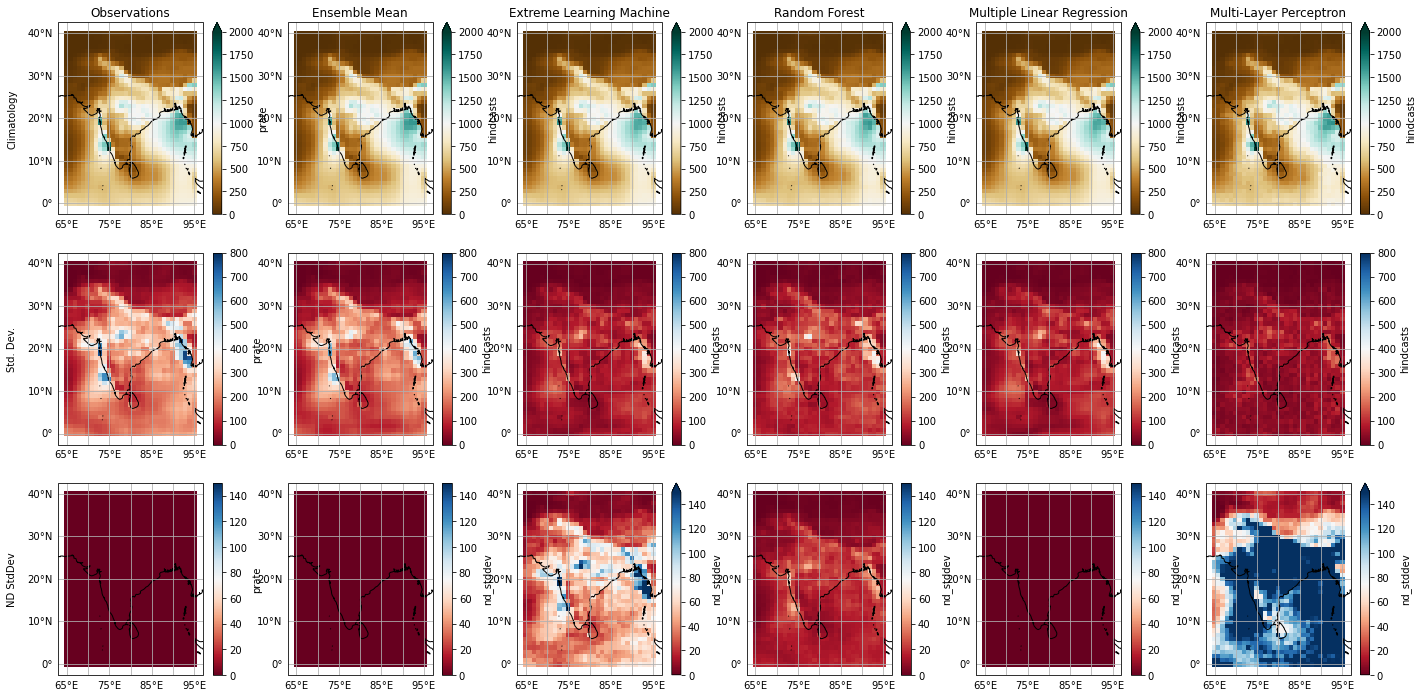

In [3]:
plots = [[Y.prate.mean('T').mean('M'), em_sm.mean('S').mean('M'), elm_sm.mean('S').mean('M'), rf_sm.mean('S').mean('M'), mlr_sm.mean('S').mean('M'), mlp_sm.mean('S').mean('M')],
        [Y.prate.std('T').mean('M'), em_sm.std('S').mean('M'), elm_sm.std('S').mean('M'), rf_sm.std('S').mean('M'), mlr_sm.std('S').mean('M'), mlp_sm.std('S').mean('M')],
        [Y.prate.std('T').mean('M')-Y.prate.std('T').mean('M'), em_sm_sd.mean('S').mean('M'), elm_sm_sd.mean('S').mean('M'), rf_sm_sd.mean('S').mean('M'), mlr_sm_sd.mean('S').mean('M'), mlp_sm_sd.mean('S').mean('M')]]
titles = ['Observations', 'Ensemble Mean', 'Extreme Learning Machine', 'Random Forest', 'Multiple Linear Regression', 'Multi-Layer Perceptron']
variables = ['Climatology', 'Std. Dev.', 'ND StdDev']
vmax = [2000, 800, 150]
cmaps = ['BrBG', 'RdBu', 'RdBu']
fig, axes = plt.subplots(nrows=3, ncols=6, sharex=True, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(24, 12))

for i in range(len(plots)):
    axes[i][0].text(-0.35,0.5,variables[i],rotation=90,verticalalignment='center', transform=axes[i][0].transAxes)
    for j in range(len(plots[0])):
        axes[0][j].set_title(titles[j])
        plots[i][j].plot(ax=axes[i][j], cmap=cmaps[i], vmin=0, vmax=vmax[i])
        axes[i][j].coastlines()
        gl = axes[i][j].gridlines()
        gl.xlabels_bottom, gl.ylabels_left = True, True
        
        


### Skill Metrics 
Here we plot skill metrics calculated with the XCast.deterministic_skill function, between the cross-validated hindcasts and the predictand dataset. This function uses the [XSkillScore](https://xskillscore.readthedocs.io/en/stable/) deterministic functions to compute all skill scores. 

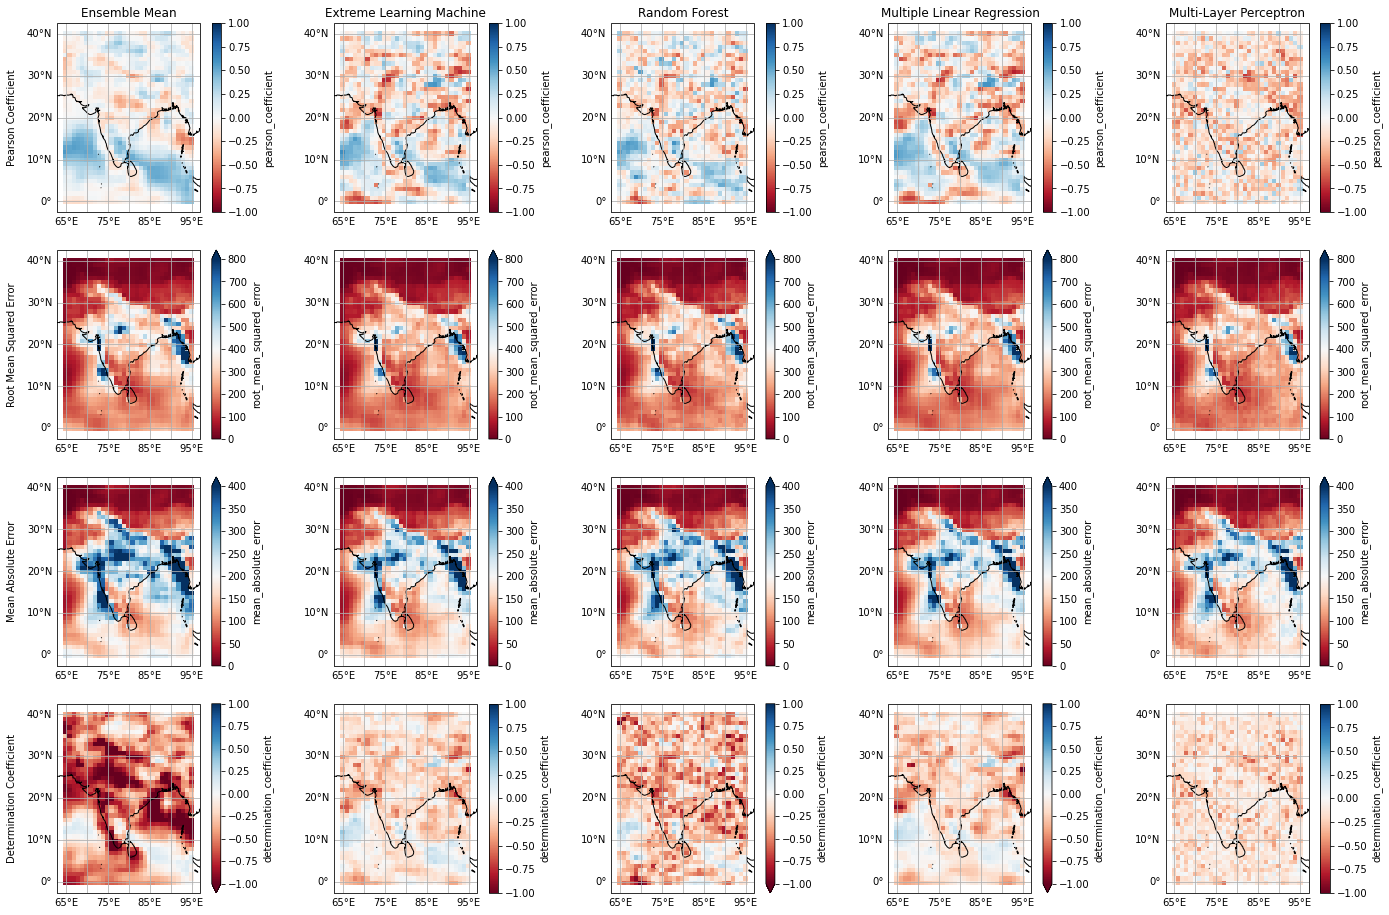

In [4]:
plots = [[em_skill.pearson_coefficient.mean('member'), elm_skill.pearson_coefficient.mean('member'), rf_skill.pearson_coefficient.mean('member'), mlr_skill.pearson_coefficient.mean('member'), mlp_skill.pearson_coefficient.mean('member')], 
        [em_skill.root_mean_squared_error.mean('member'), elm_skill.root_mean_squared_error.mean('member'), rf_skill.root_mean_squared_error.mean('member'), mlr_skill.root_mean_squared_error.mean('member'), mlp_skill.root_mean_squared_error.mean('member')], 
        [em_skill.mean_absolute_error.mean('member'), elm_skill.mean_absolute_error.mean('member'), rf_skill.mean_absolute_error.mean('member'), mlr_skill.mean_absolute_error.mean('member'), mlp_skill.mean_absolute_error.mean('member')],
        [em_skill.determination_coefficient.mean('member'), elm_skill.determination_coefficient.mean('member'), rf_skill.determination_coefficient.mean('member'), mlr_skill.determination_coefficient.mean('member'), mlp_skill.determination_coefficient.mean('member')]]
titles = ['Ensemble Mean', 'Extreme Learning Machine', 'Random Forest', 'Multiple Linear Regression', 'Multi-Layer Perceptron']
variables = ['Pearson Coefficient', 'Root Mean Squared Error', 'Mean Absolute Error', 'Determination Coefficient']
vmins, vmaxs = [-1, 0, 0, -1], [1, 800, 400, 1]
cmaps = ['RdBu', 'RdBu', 'RdBu', 'RdBu']
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, subplot_kw={'projection':ccrs.PlateCarree()}, figsize=(24, 16))

for i in range(len(plots)):
    axes[i][0].text(-0.35,0.5,variables[i],rotation=90,verticalalignment='center', transform=axes[i][0].transAxes)
    for j in range(len(plots[0])):
        axes[0][j].set_title(titles[j])
        plots[i][j].plot(ax=axes[i][j], cmap=cmaps[i], vmin=vmins[i], vmax=vmaxs[i])
        axes[i][j].coastlines()
        gl = axes[i][j].gridlines()
        gl.xlabels_bottom, gl.ylabels_left = True, True
        

### Point Skill & Point Hindcasts
We can also examine skill and hindcasts at a single point or over an aggregation of a region of space. Based on the above, it looks like there should be some skill in the South of India for this forecast, so we will aggregate over the region LAT 10:15 and LON 75:80, then calculate skill. 

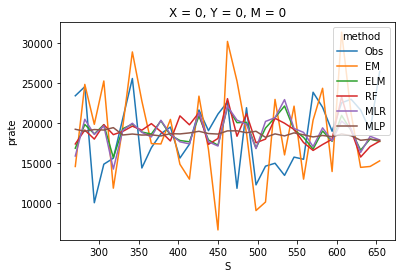

In [6]:
south_india_obs = Y.prate.sel(X=slice(75, 80), Y=slice(10,15)).sum('X').sum('Y').expand_dims({'X':[0], 'Y':[0]})
south_india_obs.coords['T'] = em_sm.coords['S'].values
south_india_em = em_sm.sel(X=slice(75, 80), Y=slice(10,15)).sum('X').sum('Y').expand_dims({'X':[0], 'Y':[0]})
south_india_elm = elm_sm.sel(X=slice(75, 80), Y=slice(10,15)).sum('X').sum('Y').expand_dims({'X':[0], 'Y':[0]})
south_india_rf = rf_sm.sel(X=slice(75, 80), Y=slice(10,15)).sum('X').sum('Y').expand_dims({'X':[0], 'Y':[0]})
south_india_mlr = mlr_sm.sel(X=slice(75, 80), Y=slice(10,15)).sum('X').sum('Y').expand_dims({'X':[0], 'Y':[0]})
south_india_mlp = mlp_sm.sel(X=slice(75, 80), Y=slice(10,15)).sum('X').sum('Y').expand_dims({'X':[0], 'Y':[0]})

hcsts  = xr.concat([south_india_obs.rename({'T':'S'}), south_india_em, south_india_elm, south_india_rf, south_india_mlr, south_india_mlp], 'method').assign_coords({'method':['Obs', 'EM', 'ELM', 'RF', 'MLR', 'MLP']})
x = hcsts.isel(X=0, Y=0, M=0).plot.line(x='S', hue='method')

In [7]:
em_skill_si = xc.deterministic_skill(south_india_em, south_india_obs, x_sample_dim='S').mean('lon').mean('lat').mean('member')
elm_skill_si = xc.deterministic_skill(south_india_elm, south_india_obs, x_sample_dim='S').mean('lon').mean('lat').mean('member')
rf_skill_si = xc.deterministic_skill(south_india_rf, south_india_obs, x_sample_dim='S').mean('lon').mean('lat').mean('member')
mlr_skill_si = xc.deterministic_skill(south_india_mlr, south_india_obs, x_sample_dim='S').mean('lon').mean('lat').mean('member')
mlp_skill_si = xc.deterministic_skill(south_india_mlp, south_india_obs, x_sample_dim='S').mean('lon').mean('lat').mean('member')

south_india_skills = xr.concat([em_skill_si, elm_skill_si, rf_skill_si, mlr_skill_si, mlp_skill_si], 'method').assign_coords({'method':[ 'EM', 'ELM', 'RF', 'MLR', 'MLP']})
south_india_skills

<xarray.Dataset>
Dimensions:                                   (method: 5)
Coordinates:
  * method                                    (method) <U3 'EM' 'ELM' ... 'MLP'
Data variables: (12/16)
    symmetric_mean_absolute_percentage_error  (method) float64 0.1427 ... 0.1025
    root_mean_squared_error                   (method) float64 6.377e+03 ... ...
    median_absolute_error                     (method) float64 3.757e+03 ... ...
    mean_squared_error                        (method) float64 4.066e+07 ... ...
    mean_error                                (method) float64 -33.87 ... 130.8
    mean_absolute_percentage_error            (method) float64 0.2992 ... 0.2205
    ...                                        ...
    slope_linear_fit                          (method) float64 0.3623 ... -0....
    pearson_p_value                           (method) float64 0.1506 ... 0.0...
    pearson_effective_p_value                 (method) float64 0.1506 ... 0.127
    effective_sample_size                     (method) float64 33.0 ... 28.0
    spearman_coefficient                      (method) float64 0.2547 ... -0....
    pearson_coefficient                       (method) float64 0.2559 ... -0....